# Imports

In [1]:
# !python -m spacy download nl_core_news_sm
# !python -m spacy download nl_core_news_md
# !python -m spacy download nl_core_news_lg

# !pip install spacy
# !pip install spacy[transformers]
# !pip install spacy-lookups-data

In [2]:
# to switch Spacy versions:

# !pip install spacy==2.3.9
# !pip install spacy==3.8.2

import spacy
print(f"Spacy version: {spacy.__version__}")

Spacy version: 3.8.2


In [3]:
# In case an uninstall is required:

# !pip uninstall -y spacy
# !python -m spacy.cli.remove-cache

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import spacy
import random
import spacy.training.loop
from spacy import displacy
from spacy.scorer import Scorer
from spacy.tokens import DocBin, Doc
from spacy.training import Example
from spacy.training.loop import train
from spacy.training.example import Example
from spacy.training.initialize import init_nlp
from spacy.util import registry, minibatch
from pathlib import Path
from collections import Counter

In [5]:
import thinc
print(thinc.__version__)

8.3.2


# Visualize Spans

In [6]:
# Load the language model and the data
nlp = spacy.load("nl_core_news_lg")
doc_bin = DocBin().from_disk("training_spans_lg.spacy")
docs = list(doc_bin.get_docs(nlp.vocab))

In [7]:
colors = {
    "Vastgoed": "#8bc34a",  # Green
    "Ondernemingen": "#2196f3",  # Blue
    "Arbeid": "#ffeb3b",  # Yellow
    "Aansprakelijkheid & Letselschade": "#f44336",  # Red
}

In [8]:
options = {
    "spans_key": "sc",  # Adjust if your span key is different
    "colors": colors
}

displacy.render(docs[0], style="span", options=options, jupyter=True)

In [9]:
for i, doc in enumerate(docs[:5]):
    print(f"\nDoc {i+1}:")
    displacy.render(doc, style="span", options=options, jupyter=True)


Doc 1:



Doc 2:



Doc 3:



Doc 4:



Doc 5:


# Training SpanCat Model

This is our initial implementation, we use no testing set yet, we only train and validate to see if we get a functional model

In [10]:
# Add the spancat component
spancat = nlp.add_pipe("spancat", config={"spans_key": "sc"}, last=True)

# Define the 4 labels
spancat.add_label("Vastgoed")
spancat.add_label("Ondernemingen")
spancat.add_label("Arbeid")
spancat.add_label("Aansprakelijkheid & Letselschade")

1

In [11]:
# Reload training data
doc_bin = spacy.tokens.DocBin().from_disk("training_spans_lg.spacy")
docs = list(doc_bin.get_docs(nlp.vocab))

# Create Example objects directly from the docs
train_data = [Example(d, d) for d in docs]

# Shuffle and split
random.shuffle(train_data)
split = int(len(train_data) * 0.8)
train_examples = train_data[:split]
dev_examples = train_data[split:] # This is the validation set, in NLP this set is refered to as the development set

In [12]:
# Start training
nlp.begin_training()
train(nlp, train_examples, dev_examples, n_iter=10)  # Train for 10 iterations

# Save trained model
nlp.to_disk("output_spancat_lg")

TypeError: train() got an unexpected keyword argument 'n_iter'

In [13]:
# Initialize the model
optimizer = nlp.initialize()

# Number of training iterations (epochs)
n_iter = 10

# Training loop
for i in range(n_iter):
    print(f"Epoch {i+1}/{n_iter}")
    random.shuffle(train_examples)
    losses = {}

    # Use minibatch training for efficiency
    batches = minibatch(train_examples, size=8)
    for batch in batches:
        nlp.update(batch, sgd=optimizer, losses=losses)

    print(f"Losses: {losses}")

# Save the trained model to a specific directory
output_dir = "output_spancat_lg"
nlp.to_disk(output_dir)

Epoch 1/10
Losses: {'tok2vec': 1220.7813847661018, 'morphologizer': 38049.978286743164, 'tagger': 38763.95851135254, 'parser': 54790.68990325928, 'lemmatizer': 39094.75476074219, 'ner': 0.0, 'spancat': 22608.18000793457}
Epoch 2/10
Losses: {'tok2vec': 2583.8853815197945, 'morphologizer': 35934.77713012695, 'tagger': 36884.43135070801, 'parser': 50757.25750350952, 'lemmatizer': 24860.333857536316, 'ner': 0.0, 'spancat': 308.6923656463623}
Epoch 3/10
Losses: {'tok2vec': 2119.6468755254064, 'morphologizer': 34271.61241149902, 'tagger': 34893.637619018555, 'parser': 44697.6824092865, 'lemmatizer': 157.569598800299, 'ner': 0.0, 'spancat': 308.4513530731201}
Epoch 4/10
Losses: {'tok2vec': 2194.8044261638343, 'morphologizer': 30218.578674316406, 'tagger': 31512.440216064453, 'parser': 40987.55151176453, 'lemmatizer': 0.4148046058971886, 'ner': 0.0, 'spancat': 307.9461078643799}
Epoch 5/10
Losses: {'tok2vec': 2820.7224880448184, 'morphologizer': 23623.011726379395, 'tagger': 25031.334266662598

The model above does not seem to yield any predictions.

# Plotting Span Length Frequency

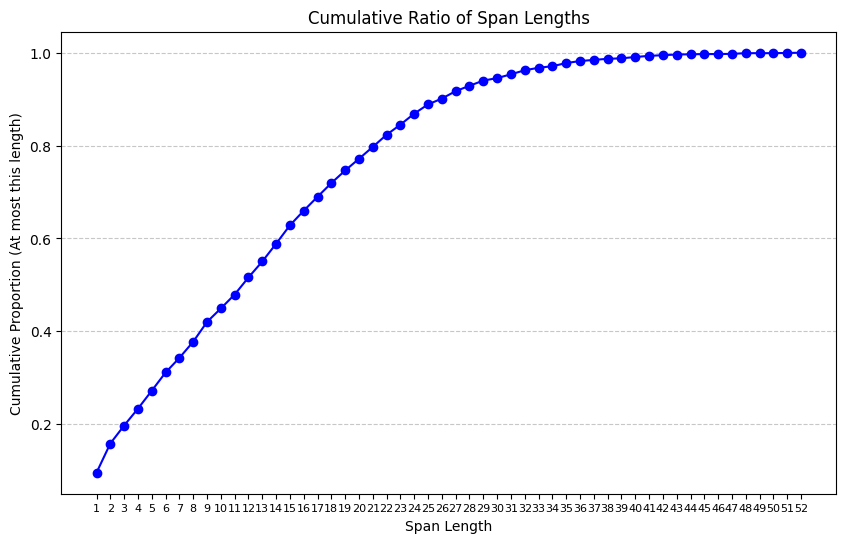

In [14]:
#Obtain the frequency per span length
span_lengths = []
for doc in docs:
    for span in doc.spans.get("sc", []):
        span_lengths.append(len(span))
span_length_counts = np.bincount(span_lengths, minlength=max(span_lengths) + 1)

# Calculate the cumulative sum
cumulative_counts = np.cumsum(span_length_counts)

# Convert to ratio
total_spans = len(span_lengths)
cumulative_ratio = cumulative_counts / total_spans

# Plot cumulative ratio
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_ratio)), cumulative_ratio[1:], marker='o', linestyle='-', color='b')
plt.xlabel('Span Length')
plt.ylabel('Cumulative Proportion (At most this length)')
plt.title('Cumulative Ratio of Span Lengths')
plt.xticks(range(1, max(span_lengths) + 1), fontsize=8)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [15]:
# Find the lowest span length where the cumulative ratio is at least 0.9
threshold = 0.9
for span_length, ratio in enumerate(cumulative_ratio[1:], start=1):  # Start at 1 since we skip the first entry (span length 0)
    if ratio >= threshold:
        print(f"Lowest span length with cumulative ratio >= {threshold}: {span_length}")
        break

Lowest span length with cumulative ratio >= 0.9: 26


# Including Test Set

Now that we confirmed that the training code works, we keep 15\% of the data for testing purpuses

In [7]:
# Load the language model and the data
nlp = spacy.load("nl_core_news_lg")
doc_bin = DocBin().from_disk("training_spans_lg.spacy")
docs = list(doc_bin.get_docs(nlp.vocab))

# Add the spancat component
spancat = nlp.add_pipe("spancat", config={"spans_key": "sc"}, last=True)

# Define the 4 labels
spancat.add_label("Vastgoed")
spancat.add_label("Ondernemingen")
spancat.add_label("Arbeid")
spancat.add_label("Aansprakelijkheid & Letselschade")

# Save the config (optional)
nlp.config.to_disk("config.cfg")

In [8]:
# Reload training data
doc_bin = spacy.tokens.DocBin().from_disk("training_spans_lg.spacy")
docs = list(doc_bin.get_docs(nlp.vocab))

# Create Example objects directly from the docs
train_data = [Example(d, d) for d in docs]

# Shuffle all examples
random.shuffle(train_data)

# Calculate split points
total = len(train_data)
train_split = int(total * 0.7)
dev_split = int(total * 0.85)

# Split data
train_examples = train_data[:train_split]
dev_examples = train_data[train_split:dev_split]
test_examples = train_data[dev_split:]

In [9]:
# Initialize the model
optimizer = nlp.initialize()

# Number of training iterations (epochs)
n_iter = 10

# Training loop
for i in range(n_iter):
    print(f"Epoch {i+1}/{n_iter}")
    random.shuffle(train_examples)
    losses = {}

    # Use minibatch training for efficiency
    batches = minibatch(train_examples, size=8)
    for batch in batches:
        nlp.update(batch, sgd=optimizer, losses=losses)

    print(f"Losses: {losses}")

# Save the trained model to a specific directory
output_dir = "output_spancat_lg"
nlp.to_disk(output_dir)

Epoch 1/10
Losses: {'tok2vec': 862.6406673621386, 'morphologizer': 32237.63558959961, 'tagger': 32775.65223693848, 'parser': 48781.86174535751, 'lemmatizer': 33021.064544677734, 'ner': 0.0, 'spancat': 37045.07239961624}
Epoch 2/10
Losses: {'tok2vec': 2649.61439037323, 'morphologizer': 30684.26092529297, 'tagger': 31400.31039428711, 'parser': 48524.02906012535, 'lemmatizer': 22577.132160186768, 'ner': 0.0, 'spancat': 246.21716117858887}
Epoch 3/10
Losses: {'tok2vec': 1680.682883368805, 'morphologizer': 29711.772064208984, 'tagger': 30310.353485107422, 'parser': 36458.08159124851, 'lemmatizer': 405.01100475899875, 'ner': 0.0, 'spancat': 245.67471885681152}
Epoch 4/10
Losses: {'tok2vec': 2087.3991384489564, 'morphologizer': 27203.547912597656, 'tagger': 27928.950881958008, 'parser': 35240.428248524666, 'lemmatizer': 7.83680599485524, 'ner': 0.0, 'spancat': 245.54539728164673}
Epoch 5/10
Losses: {'tok2vec': 2265.2076289735624, 'morphologizer': 22286.023330688477, 'tagger': 23413.3968811035

In [13]:
# Load the trained model
nlp_trained = spacy.load("output_spancat_lg")

# Score it on the test set
scorer = Scorer()

for example in test_examples:
    # Get the model's prediction
    doc_pred = nlp_trained(example.text)
    
    # Create a list of predicted spans in the correct format
    predicted_spans = []
    for span in doc_pred.spans["sc"]:  # "sc" is the spans_key
        predicted_spans.append({
            "start": span.start_char, 
            "end": span.end_char, 
            "label": span.label_
        })

    # Create the Example object for prediction and reference
    example_pred = Example.from_dict(doc_pred, {"spans": predicted_spans})
    example_ref = Example.from_dict(example.reference, {"spans": example.reference.spans})
    
    # Score the prediction against the reference
    scorer.score(example_pred, example_ref)

# Print out the scoring metrics (precision, recall, F1)
print(scorer.score)

ValueError: [E879] Unexpected type for 'spans' data. Provide a dictionary mapping keys to a list of spans, with each span represented by a tuple (start_char, end_char). The tuple can be optionally extended with a label and a KB ID.

In [14]:
{"spans": predicted_spans}

{'spans': []}

In [15]:
doc_pred.spans["sc"]

[]

In [17]:
for example in test_examples:
    # Get the model's prediction
    doc_pred = nlp_trained(example.text)
    print(doc_pred)

C:\Users\20193204\AppData\Roaming\Python\Python310\site-packages\spacy\pipeline\attributeruler.py:149: UserWarning: [W036] The component 'matcher' does not have any patterns defined.
  matches = self.matcher(doc, allow_missing=True, as_spans=False)


Aardschok in Duitsland: Volkswagen dreigt minstens drie fabrieken te sluiten.  
De directie van Volkswagen kiest voor een confrontatie met vakbond IG Metall en de 
ondernemingsraad in een poging het autoconcern winstgevender te krijgen. De or wijst de 
saneringsplannen af.  
Ingrijpende saneringsplannen bij autofabrikant Volkswagen hebben maandag de politieke 
discussie over de economische malaise in Duitsland op scherp gezet. De Duitse regering komt 
onder druk te staan om een snoeiharde sanering bij de belangrijkste autobouwer van het 
land te voorkomen.  
De Beierse christendemocratische minister-president Markus Söder stelde na het nieuws dat 
Volkswagen erop zint minstens drie fabrieken te sluiten en tienduizenden banen te 
schrappen, dat Duitsland een ‘auto-Marshallplan nodig heeft’. Daarbij hoort dat de EU het 
plan opschort om in 2035 te stoppen met auto’s met een verbrandingsmotor.  
Ook moeten van hem de dreigende Europese CO2-boetes van tafel voor automakers wier 
vloot per 

In [18]:
# Load the trained model
nlp_trained = spacy.load("output_spancat_lg")

# Loop through your test set and evaluate
for example in test_examples:
    # Get the model's prediction
    doc_pred = nlp_trained(example.text)

    # Check if any spans are detected
    print(f"Detected spans for {example.text}:")
    for span in doc_pred.spans:
        print(f"Spans Key: {span}, Spans: {doc_pred.spans[span]}")  # List spans for all keys

    # If no spans, check if the span detection is working
    if not doc_pred.spans:
        print(f"No spans detected for: {example.text}")
    else:
        # If spans exist, try to extract the correct spans
        predicted_spans = []
        for span in doc_pred.spans.get("sc", []):  # "sc" should be the spans_key
            predicted_spans.append({
                "start": span.start_char, 
                "end": span.end_char, 
                "label": span.label_
            })
        print(f"Predicted spans: {predicted_spans}")

Detected spans for Aardschok in Duitsland: Volkswagen dreigt minstens drie fabrieken te sluiten.  
De directie van Volkswagen kiest voor een confrontatie met vakbond IG Metall en de 
ondernemingsraad in een poging het autoconcern winstgevender te krijgen. De or wijst de 
saneringsplannen af.  
Ingrijpende saneringsplannen bij autofabrikant Volkswagen hebben maandag de politieke 
discussie over de economische malaise in Duitsland op scherp gezet. De Duitse regering komt 
onder druk te staan om een snoeiharde sanering bij de belangrijkste autobouwer van het 
land te voorkomen.  
De Beierse christendemocratische minister-president Markus Söder stelde na het nieuws dat 
Volkswagen erop zint minstens drie fabrieken te sluiten en tienduizenden banen te 
schrappen, dat Duitsland een ‘auto-Marshallplan nodig heeft’. Daarbij hoort dat de EU het 
plan opschort om in 2035 te stoppen met auto’s met een verbrandingsmotor.  
Ook moeten van hem de dreigende Europese CO2-boetes van tafel voor automake

# Finding confidence per span

In [26]:
# Load the language model and the data
nlp = spacy.load("nl_core_news_lg")
doc_bin = DocBin().from_disk("training_spans_lg.spacy")
docs = list(doc_bin.get_docs(nlp.vocab))

# Add the spancat component
spancat = nlp.add_pipe("spancat", config={
    "spans_key": "sc",
    "threshold": 0.2  # You can still set the threshold for span categorization
}, last=True)

# Define the 4 labels
spancat.add_label("Vastgoed")
spancat.add_label("Ondernemingen")
spancat.add_label("Arbeid")
spancat.add_label("Aansprakelijkheid & Letselschade")

# Save the config (optional)
nlp.config.to_disk("config.cfg")

# Create Example objects directly from the docs
train_data = [Example(d, d) for d in docs]

# Shuffle all examples
random.seed(3479220)
random.shuffle(train_data)

# Calculate split points
total = len(train_data)
train_split = int(total * 0.7)
dev_split = int(total * 0.85)

# Split data
train_examples = train_data[:train_split]
dev_examples = train_data[train_split:dev_split]
test_examples = train_data[dev_split:]

# Initialize the model
optimizer = nlp.initialize()

# Number of training iterations (epochs)
n_iter = 10

# Training loop
for i in range(n_iter):
    print(f"Epoch {i+1}/{n_iter}")
    random.shuffle(train_examples)
    losses = {}

    # Use minibatch training for efficiency
    from spacy.util import minibatch
    batches = minibatch(train_examples, size=8)
    for batch in batches:
        nlp.update(batch, sgd=optimizer, losses=losses)

    print(f"Losses: {losses}")

# Save the trained model to a specific directory
output_dir = "output_spancat_lg"
nlp.to_disk(output_dir)

Epoch 1/10
Losses: {'tok2vec': 828.0176266431808, 'morphologizer': 33495.80618286133, 'tagger': 34067.25067138672, 'parser': 48673.39141654968, 'lemmatizer': 34325.04780578613, 'ner': 0.0, 'spancat': 48256.22312259674}
Epoch 2/10
Losses: {'tok2vec': 2311.638563811779, 'morphologizer': 31772.055877685547, 'tagger': 32433.61976623535, 'parser': 44937.76104640961, 'lemmatizer': 20939.73825263977, 'ner': 0.0, 'spancat': 289.60502004623413}
Epoch 3/10
Losses: {'tok2vec': 1656.8341373061266, 'morphologizer': 30608.939819335938, 'tagger': 31203.899536132812, 'parser': 40763.797082304955, 'lemmatizer': 152.20200914354064, 'ner': 0.0, 'spancat': 287.2563319206238}
Epoch 4/10
Losses: {'tok2vec': 2096.9906590569235, 'morphologizer': 27773.500198364258, 'tagger': 28693.104034423828, 'parser': 38230.85059142113, 'lemmatizer': 0.6857165239484857, 'ner': 0.0, 'spancat': 278.84831619262695}
Epoch 5/10
Losses: {'tok2vec': 2530.473169897753, 'morphologizer': 22585.87651824951, 'tagger': 23737.3821487426

In [48]:
# Pick a test example
example = test_examples[0]

# Use the test example's reference doc
doc = example.reference

# Convert text to new doc via tokenizer (if not already done)
doc = nlp.make_doc(doc.text)

# Run the pipeline up to the spancat component
predictions = nlp.get_pipe("spancat").predict([doc])

# Set annotations on the doc based on those predictions
nlp.get_pipe("spancat").set_annotations([doc], predictions)

# Now get the scored spans
spans = doc.spans["sc"]

# Unfortunately, span.score isn't available, but we can get scores manually
# via the Spancat’s predict method, which returns scores for candidate spans

# Example: get the predicted scores for spans in the doc
scores = nlp.get_pipe("spancat").predict([doc])[0]  # just one doc here
# print(scores.keys())
print(scores)

Ragged(data=array([[   0,    1],
       [   1,    2],
       [   2,    3],
       ...,
       [1300, 1303],
       [1301, 1304],
       [1302, 1305]]), lengths=array([3912]), data_shape=(-1, 2), starts_ends=None)


In [45]:
nlp.get_pipe("spancat").predict([doc])

(Ragged(data=array([[   0,    1],
        [   1,    2],
        [   2,    3],
        ...,
        [1300, 1303],
        [1301, 1304],
        [1302, 1305]]), lengths=array([3912]), data_shape=(-1, 2), starts_ends=None),
 array([[1.5507017e-04, 6.4865932e-02, 8.4666644e-05, 1.6447941e-04],
        [3.5932771e-04, 2.6824868e-03, 1.2058189e-04, 1.3446168e-04],
        [2.8597016e-04, 1.7409291e-03, 1.9577135e-04, 2.1085711e-04],
        ...,
        [2.2239027e-04, 6.6113234e-03, 1.0821175e-04, 1.3718632e-04],
        [3.3788182e-04, 2.4922439e-03, 9.2018890e-05, 1.7754915e-04],
        [2.1568601e-04, 3.2733686e-03, 9.9428551e-05, 1.8704669e-04]],
       dtype=float32))

In [52]:
# Get your test doc text
example = test_examples[0]
text = example.reference.text
doc = nlp.make_doc(text)

# Predict spans and scores
spancat = nlp.get_pipe("spancat")
predictions = spancat.predict([doc])

# Set predicted annotations (populates doc.spans["sc"])
spancat.set_annotations([doc], predictions)

# Labels and scores
labels = spancat.labels
spans = predictions[0]["spans"]
score_values = predictions[0]["scores"]

# Map scores to spans
for (start, end), span_scores in zip(spans, score_values):
    span_text = doc[start:end].text
    for label, score in zip(labels, span_scores):
        print(f"Span: '{span_text}', Label: {label}, Score: {score:.3f}")

ValueError: invalid literal for int() with base 10: 's'

In [53]:
predictions

(Ragged(data=array([[   0,    1],
        [   1,    2],
        [   2,    3],
        ...,
        [1300, 1303],
        [1301, 1304],
        [1302, 1305]]), lengths=array([3912]), data_shape=(-1, 2), starts_ends=array([   0, 3912], dtype=int32)),
 array([[1.5507017e-04, 6.4865932e-02, 8.4666644e-05, 1.6447941e-04],
        [3.5932771e-04, 2.6824868e-03, 1.2058189e-04, 1.3446168e-04],
        [2.8597016e-04, 1.7409291e-03, 1.9577135e-04, 2.1085711e-04],
        ...,
        [2.2239027e-04, 6.6113234e-03, 1.0821175e-04, 1.3718632e-04],
        [3.3788182e-04, 2.4922439e-03, 9.2018890e-05, 1.7754915e-04],
        [2.1568601e-04, 3.2733686e-03, 9.9428551e-05, 1.8704669e-04]],
       dtype=float32))

In [69]:
print(predictions[0])

Ragged(data=array([[   0,    1],
       [   1,    2],
       [   2,    3],
       ...,
       [1300, 1303],
       [1301, 1304],
       [1302, 1305]]), lengths=array([3912]), data_shape=(-1, 2), starts_ends=array([   0, 3912], dtype=int32))


In [72]:
# Get predicted spans and scores
pred_spans = predictions[0].data.tolist()  # (n_spans, 2)
pred_scores = predictions[1].data.tolist()  # (n_spans, n_labels)

In [74]:
pred_scores

[[0.00015507017087657005,
  0.06486593186855316,
  8.466664439765736e-05,
  0.0001644794101594016],
 [0.00035932770697399974,
  0.002682486781850457,
  0.00012058189167873934,
  0.00013446167577058077],
 [0.00028597016353160143,
  0.0017409290885552764,
  0.0001957713539013639,
  0.0002108571061398834],
 [0.0003181426727678627,
  0.006025577895343304,
  8.626907947473228e-05,
  0.0001812636764952913],
 [0.00016878756287042052,
  0.020900174975395203,
  0.00014048186130821705,
  0.00013303520972840488],
 [0.00021730849402956665,
  0.012465210631489754,
  9.14146366994828e-05,
  0.00014714806457050145],
 [0.00021538310102187097,
  0.011088560335338116,
  0.00011836925841635093,
  0.00013006133667659014],
 [0.00036958642886020243,
  0.001013587461784482,
  0.00021062239829916507,
  0.00028011322137899697],
 [0.00019460722978692502,
  0.005502910353243351,
  0.00013687364116776735,
  0.0001615043729543686],
 [0.000137577488203533,
  0.016466183587908745,
  0.00011173051461810246,
  0.00014

In [76]:
def print_span_predictions(nlp, text, spans_key="sc"):
    doc = nlp.make_doc(text)
    spancat = nlp.get_pipe("spancat")
    predictions = spancat.predict([doc])
    spancat.set_annotations([doc], predictions)
    
    labels = spancat.labels
    pred_spans = predictions[0].data.tolist()
    pred_scores = predictions[1].data.tolist()
    
    for (start, end), span_scores in zip(pred_spans, pred_scores):
        span_text = doc[start:end].text
        for label, score in zip(labels, span_scores):
            print(f"Span: '{span_text}', Label: {label}, Score: {score:.3f}")

# Example usage:
print_span_predictions(nlp, example.reference.text)

Span: 'Zorg-zzp', Label: Vastgoed, Score: 0.000
Span: 'Zorg-zzp', Label: Ondernemingen, Score: 0.065
Span: 'Zorg-zzp', Label: Arbeid, Score: 0.000
Span: 'Zorg-zzp', Label: Aansprakelijkheid & Letselschade, Score: 0.000
Span: '’', Label: Vastgoed, Score: 0.000
Span: '’', Label: Ondernemingen, Score: 0.003
Span: '’', Label: Arbeid, Score: 0.000
Span: '’', Label: Aansprakelijkheid & Letselschade, Score: 0.000
Span: 'ers', Label: Vastgoed, Score: 0.000
Span: 'ers', Label: Ondernemingen, Score: 0.002
Span: 'ers', Label: Arbeid, Score: 0.000
Span: 'ers', Label: Aansprakelijkheid & Letselschade, Score: 0.000
Span: 'willen', Label: Vastgoed, Score: 0.000
Span: 'willen', Label: Ondernemingen, Score: 0.006
Span: 'willen', Label: Arbeid, Score: 0.000
Span: 'willen', Label: Aansprakelijkheid & Letselschade, Score: 0.000
Span: 'duidelijkheid', Label: Vastgoed, Score: 0.000
Span: 'duidelijkheid', Label: Ondernemingen, Score: 0.021
Span: 'duidelijkheid', Label: Arbeid, Score: 0.000
Span: 'duidelijkhe

# Experimental

In [9]:
# Load the language model and the data
nlp = spacy.load("nl_core_news_lg")
doc_bin = DocBin().from_disk("training_spans_lg.spacy")
docs = list(doc_bin.get_docs(nlp.vocab))

# Add the spancat component
spancat = nlp.add_pipe("spancat", config={
    "spans_key": "sc",
    "threshold": 0.2  # You can still set the threshold for span categorization
}, last=True)

# Define the 4 labels
spancat.add_label("Vastgoed")
spancat.add_label("Ondernemingen")
spancat.add_label("Arbeid")
spancat.add_label("Aansprakelijkheid & Letselschade")

# Save the config (optional)
nlp.config.to_disk("config.cfg")

# Create Example objects directly from the docs
train_data = [Example(d, d) for d in docs]

# Shuffle all examples
random.seed(3479220)
random.shuffle(train_data)

# Calculate split points
total = len(train_data)
train_split = int(total * 0.7)
dev_split = int(total * 0.85)

# Split data
train_examples = train_data[:train_split]
dev_examples = train_data[train_split:dev_split]
test_examples = train_data[dev_split:]

# Initialize the model
optimizer = nlp.initialize()

# Number of training iterations (epochs)
n_iter = 50

# Training loop
for i in range(n_iter):
    print(f"Epoch {i+1}/{n_iter}")
    random.shuffle(train_examples)
    losses = {}

    # Use minibatch training for efficiency
    from spacy.util import minibatch
    batches = minibatch(train_examples, size=8)
    for batch in batches:
        nlp.update(batch, sgd=optimizer, losses=losses)

    print(f"Losses: {losses}")

# Save the trained model to a specific directory
output_dir = "output_spancat_lg"
nlp.to_disk(output_dir)

Epoch 1/50
Losses: {'tok2vec': 791.8947021961212, 'morphologizer': 33549.74668884277, 'tagger': 34097.9606628418, 'parser': 51408.89825820923, 'lemmatizer': 34343.20420837402, 'ner': 0.0, 'spancat': 39734.27182197571}
Epoch 2/50
Losses: {'tok2vec': 4978.791742444038, 'morphologizer': 31578.13282775879, 'tagger': 32422.522705078125, 'parser': 51227.45733642578, 'lemmatizer': 23595.13856124878, 'ner': 0.0, 'spancat': 288.7047829627991}
Epoch 3/50
Losses: {'tok2vec': 2108.0892778029665, 'morphologizer': 30387.001983642578, 'tagger': 31073.384719848633, 'parser': 41153.24673116207, 'lemmatizer': 357.6257635084912, 'ner': 0.0, 'spancat': 287.3350212574005}
Epoch 4/50
Losses: {'tok2vec': 2363.9209007273207, 'morphologizer': 27856.36781311035, 'tagger': 28671.02262878418, 'parser': 35172.45212984085, 'lemmatizer': 3.052980866867074, 'ner': 0.0, 'spancat': 284.10075521469116}
Epoch 5/50
Losses: {'tok2vec': 3075.2424647798694, 'morphologizer': 22861.56610107422, 'tagger': 24044.946266174316, 'p

In [10]:
# Test the trained model on a single new document (e.g., a sentence or text)
test_text = "Werknemers klagen hun werkgever aan vanwege de slechte werkomstandigheden."
doc = nlp(test_text)

# Print the spans detected by the model
predicted_spans = doc.spans.get("sc", [])
print(f"Text: {test_text}")
print(f"Predicted spans:")
for span in predicted_spans:
    print(f"  - Span: {span.text}, Label: {span.label_}")

Text: Werknemers klagen hun werkgever aan vanwege de slechte werkomstandigheden.
Predicted spans:


C:\Users\20193204\AppData\Roaming\Python\Python310\site-packages\spacy\pipeline\attributeruler.py:149: UserWarning: [W036] The component 'matcher' does not have any patterns defined.
  matches = self.matcher(doc, allow_missing=True, as_spans=False)


In [11]:
# Test the model on test examples
for doc in test_examples[:5]:  # Test on first 5 examples
    pred_doc = nlp(doc.text)  # Run model on raw text
    spans = pred_doc.spans.get("sc", [])
    print(f"Text: {pred_doc.text}")
    print(f"Predicted spans: {[ (span.text, span.label_) for span in spans ]}")

Text: Zorg-zzp’ers willen duidelijkheid over arbeidstoekomst.  
Nu de overheid wil gaan handhaven op schijnzelfstandigheid zitten zzp’ers in de zorg, hun 
opdrachtgevers en bemiddelaars met veel vragen en zorgen, blijkt op een 
informatiebijeenkomst in Utrecht. Met slechts een kleine drie maanden te gaan voordat de 
Belastingdienst weer actief gaat optreden tegen schijnzelfstandigheid, willen zij weten hoe 
het precies zit met de Wet deregulering beoordeling arbeidsrelaties (DBA). 
 
Zzp’ers in de zorg: ‘Vakkrachten hebben geen andere keuze dan loondienst’.  
Nu de overheid wil gaan handhaven op schijnzelfstandigheid zitten zzp’ers in de zorg, hun 
opdrachtgevers en bemiddelaars met veel vragen en zorgen, blijkt op een 
informatiebijeenkomst in Utrecht.  
‘Na tien jaar presentaties geven, trekken we eindelijk volle zalen’, grapt Ralph Jan van der 
Ham, arbeidsrechtspecialist bij advocatenkantoor Holla Legal & Tax. Het congreszaaltje boven 
het Utrechtse Centraal Station zit inderdaad r

In [12]:
# Visualize the spans in the test document
for doc in test_examples[:5]:  # Use the first test example for visualization
    pred_doc = nlp(doc.text)  # Run model on raw text
    displacy.render(pred_doc, style="span", page=True)

C:\Users\20193204\AppData\Roaming\Python\Python310\site-packages\spacy\displacy\__init__.py:244: UserWarning: [W117] No spans to visualize found in Doc object with spans_key: 'sc'. If this is surprising to you, make sure the Doc was processed using a model that supports span categorization, and check the `doc.spans[spans_key]` property manually if necessary.

Available keys: ['sc']
  warnings.warn(Warnings.W117.format(spans_key=spans_key, keys=keys))


In [13]:
for doc in test_examples[:5]:  # Test on first 5 examples
    pred_doc = nlp(doc.text)  # Run model on raw text
    spans = pred_doc.spans.get("sc", [])
    
    print(f"Text: {pred_doc.text}")
    
    # Print the predicted spans and their labels
    for span in spans:
        print(f"Predicted span: {span.text}, Label: {span.label_}")

Text: Zorg-zzp’ers willen duidelijkheid over arbeidstoekomst.  
Nu de overheid wil gaan handhaven op schijnzelfstandigheid zitten zzp’ers in de zorg, hun 
opdrachtgevers en bemiddelaars met veel vragen en zorgen, blijkt op een 
informatiebijeenkomst in Utrecht. Met slechts een kleine drie maanden te gaan voordat de 
Belastingdienst weer actief gaat optreden tegen schijnzelfstandigheid, willen zij weten hoe 
het precies zit met de Wet deregulering beoordeling arbeidsrelaties (DBA). 
 
Zzp’ers in de zorg: ‘Vakkrachten hebben geen andere keuze dan loondienst’.  
Nu de overheid wil gaan handhaven op schijnzelfstandigheid zitten zzp’ers in de zorg, hun 
opdrachtgevers en bemiddelaars met veel vragen en zorgen, blijkt op een 
informatiebijeenkomst in Utrecht.  
‘Na tien jaar presentaties geven, trekken we eindelijk volle zalen’, grapt Ralph Jan van der 
Ham, arbeidsrechtspecialist bij advocatenkantoor Holla Legal & Tax. Het congreszaaltje boven 
het Utrechtse Centraal Station zit inderdaad r

In [14]:
for doc in test_examples[:5]:  # Test on first 5 examples
    pred_doc = nlp.make_doc(doc.text)  # Create a Doc object without processing
    pred_doc = nlp.get_pipe("spancat")(pred_doc)  # Manually run the spancat component on the doc
    
    print(f"Text: {pred_doc.text}")
    
    # Get the candidate spans directly from the model
    candidate_spans = pred_doc.spans.get("sc", [])
    
    if candidate_spans:
        for span in candidate_spans:
            print(f"Candidate Span: {span.text}")
    else:
        print("No candidate spans found.")

Text: Zorg-zzp’ers willen duidelijkheid over arbeidstoekomst.  
Nu de overheid wil gaan handhaven op schijnzelfstandigheid zitten zzp’ers in de zorg, hun 
opdrachtgevers en bemiddelaars met veel vragen en zorgen, blijkt op een 
informatiebijeenkomst in Utrecht. Met slechts een kleine drie maanden te gaan voordat de 
Belastingdienst weer actief gaat optreden tegen schijnzelfstandigheid, willen zij weten hoe 
het precies zit met de Wet deregulering beoordeling arbeidsrelaties (DBA). 
 
Zzp’ers in de zorg: ‘Vakkrachten hebben geen andere keuze dan loondienst’.  
Nu de overheid wil gaan handhaven op schijnzelfstandigheid zitten zzp’ers in de zorg, hun 
opdrachtgevers en bemiddelaars met veel vragen en zorgen, blijkt op een 
informatiebijeenkomst in Utrecht.  
‘Na tien jaar presentaties geven, trekken we eindelijk volle zalen’, grapt Ralph Jan van der 
Ham, arbeidsrechtspecialist bij advocatenkantoor Holla Legal & Tax. Het congreszaaltje boven 
het Utrechtse Centraal Station zit inderdaad r

# Experimental with ngrams

In [15]:
# Load the language model and the data
nlp = spacy.load("nl_core_news_lg")
doc_bin = DocBin().from_disk("training_spans_lg.spacy")
docs = list(doc_bin.get_docs(nlp.vocab))

# Add the spancat component
spancat = nlp.add_pipe("spancat", config={
    "spans_key": "sc",
    "suggester": {
        "@misc": "spacy.ngram_suggester.v1",
        "sizes": [1,2,3]},
    "threshold": 0.2  # You can still set the threshold for span categorization
}, last=True)

# Define the 4 labels
spancat.add_label("Vastgoed")
spancat.add_label("Ondernemingen")
spancat.add_label("Arbeid")
spancat.add_label("Aansprakelijkheid & Letselschade")

# Save the config (optional)
nlp.config.to_disk("config.cfg")

# Create Example objects directly from the docs
train_data = [Example(d, d) for d in docs]

# Shuffle all examples
random.seed(3479220)
random.shuffle(train_data)

# Calculate split points
total = len(train_data)
train_split = int(total * 0.7)
dev_split = int(total * 0.85)

# Split data
train_examples = train_data[:train_split]
dev_examples = train_data[train_split:dev_split]
test_examples = train_data[dev_split:]

# Initialize the model
optimizer = nlp.initialize()

# Number of training iterations (epochs)
n_iter = 50

# Training loop
for i in range(n_iter):
    print(f"Epoch {i+1}/{n_iter}")
    random.shuffle(train_examples)
    losses = {}

    # Use minibatch training for efficiency
    from spacy.util import minibatch
    batches = minibatch(train_examples, size=8)
    for batch in batches:
        nlp.update(batch, sgd=optimizer, losses=losses)

    print(f"Losses: {losses}")

# Save the trained model to a specific directory
output_dir = "output_spancat_lg"
nlp.to_disk(output_dir)

Epoch 1/50
Losses: {'tok2vec': 835.632120154798, 'morphologizer': 33510.42436218262, 'tagger': 34077.3212890625, 'parser': 50644.32428646088, 'lemmatizer': 34334.08555603027, 'ner': 0.0, 'spancat': 39041.85795879364}
Epoch 2/50
Losses: {'tok2vec': 2525.726605772972, 'morphologizer': 31520.774673461914, 'tagger': 32292.98179626465, 'parser': 46143.50240302086, 'lemmatizer': 22480.400505065918, 'ner': 0.0, 'spancat': 288.590012550354}
Epoch 3/50
Losses: {'tok2vec': 1636.4362317861523, 'morphologizer': 30205.257354736328, 'tagger': 30786.085174560547, 'parser': 36965.9627661109, 'lemmatizer': 231.60529687767848, 'ner': 0.0, 'spancat': 288.146541595459}
Epoch 4/50
Losses: {'tok2vec': 2231.1631150582525, 'morphologizer': 26919.61343383789, 'tagger': 27796.72933959961, 'parser': 36573.42749166489, 'lemmatizer': 1.8124229334025586, 'ner': 0.0, 'spancat': 276.0346693992615}
Epoch 5/50
Losses: {'tok2vec': 2808.3351682960056, 'morphologizer': 21017.229621887207, 'tagger': 22167.200927734375, 'pa

In [16]:
# Test the trained model on a single new document (e.g., a sentence or text)
test_text = "Werknemers klagen hun werkgever aan vanwege de slechte werkomstandigheden."
doc = nlp(test_text)

# Print the spans detected by the model
predicted_spans = doc.spans.get("sc", [])
print(f"Text: {test_text}")
print(f"Predicted spans:")
for span in predicted_spans:
    print(f"  - Span: {span.text}, Label: {span.label_}")

Text: Werknemers klagen hun werkgever aan vanwege de slechte werkomstandigheden.
Predicted spans:


In [17]:
# Test the model on test examples
for doc in test_examples[:5]:  # Test on first 5 examples
    pred_doc = nlp(doc.text)  # Run model on raw text
    spans = pred_doc.spans.get("sc", [])
    print(f"Text: {pred_doc.text}")
    print(f"Predicted spans: {[ (span.text, span.label_) for span in spans ]}")

Text: Zorg-zzp’ers willen duidelijkheid over arbeidstoekomst.  
Nu de overheid wil gaan handhaven op schijnzelfstandigheid zitten zzp’ers in de zorg, hun 
opdrachtgevers en bemiddelaars met veel vragen en zorgen, blijkt op een 
informatiebijeenkomst in Utrecht. Met slechts een kleine drie maanden te gaan voordat de 
Belastingdienst weer actief gaat optreden tegen schijnzelfstandigheid, willen zij weten hoe 
het precies zit met de Wet deregulering beoordeling arbeidsrelaties (DBA). 
 
Zzp’ers in de zorg: ‘Vakkrachten hebben geen andere keuze dan loondienst’.  
Nu de overheid wil gaan handhaven op schijnzelfstandigheid zitten zzp’ers in de zorg, hun 
opdrachtgevers en bemiddelaars met veel vragen en zorgen, blijkt op een 
informatiebijeenkomst in Utrecht.  
‘Na tien jaar presentaties geven, trekken we eindelijk volle zalen’, grapt Ralph Jan van der 
Ham, arbeidsrechtspecialist bij advocatenkantoor Holla Legal & Tax. Het congreszaaltje boven 
het Utrechtse Centraal Station zit inderdaad r

In [18]:
# Visualize the spans in the test document
for doc in test_examples[:5]:  # Use the first test example for visualization
    pred_doc = nlp(doc.text)  # Run model on raw text
    displacy.render(pred_doc, style="span", page=True)

# Now for threshold=0.1

In [19]:
# Load the language model and the data
nlp = spacy.load("nl_core_news_lg")
doc_bin = DocBin().from_disk("training_spans_lg.spacy")
docs = list(doc_bin.get_docs(nlp.vocab))

# Add the spancat component
spancat = nlp.add_pipe("spancat", config={
    "spans_key": "sc",
    "suggester": {
        "@misc": "spacy.ngram_suggester.v1",
        "sizes": [1,2,3]},
    "threshold": 0.1  # You can still set the threshold for span categorization
}, last=True)

# Define the 4 labels
spancat.add_label("Vastgoed")
spancat.add_label("Ondernemingen")
spancat.add_label("Arbeid")
spancat.add_label("Aansprakelijkheid & Letselschade")

# Save the config (optional)
nlp.config.to_disk("config.cfg")

# Create Example objects directly from the docs
train_data = [Example(d, d) for d in docs]

# Shuffle all examples
random.seed(3479220)
random.shuffle(train_data)

# Calculate split points
total = len(train_data)
train_split = int(total * 0.7)
dev_split = int(total * 0.85)

# Split data
train_examples = train_data[:train_split]
dev_examples = train_data[train_split:dev_split]
test_examples = train_data[dev_split:]

# Initialize the model
optimizer = nlp.initialize()

# Number of training iterations (epochs)
n_iter = 50

# Training loop
for i in range(n_iter):
    print(f"Epoch {i+1}/{n_iter}")
    random.shuffle(train_examples)
    losses = {}

    # Use minibatch training for efficiency
    from spacy.util import minibatch
    batches = minibatch(train_examples, size=8)
    for batch in batches:
        nlp.update(batch, sgd=optimizer, losses=losses)

    print(f"Losses: {losses}")

# Save the trained model to a specific directory
output_dir = "output_spancat_lg"
nlp.to_disk(output_dir)

Epoch 1/50
Losses: {'tok2vec': 717.8533660769463, 'morphologizer': 33513.81880187988, 'tagger': 34073.17936706543, 'parser': 52309.76186847687, 'lemmatizer': 34330.377502441406, 'ner': 0.0, 'spancat': 41378.613077163696}
Epoch 2/50
Losses: {'tok2vec': 2843.898446083069, 'morphologizer': 31750.401458740234, 'tagger': 32478.06381225586, 'parser': 52790.76557779312, 'lemmatizer': 20832.494874954224, 'ner': 0.0, 'spancat': 289.34349179267883}
Epoch 3/50
Losses: {'tok2vec': 1554.7705404263106, 'morphologizer': 30552.010223388672, 'tagger': 31157.532958984375, 'parser': 38794.43673944473, 'lemmatizer': 220.5243522527162, 'ner': 0.0, 'spancat': 288.15906953811646}
Epoch 4/50
Losses: {'tok2vec': 2281.4388074787275, 'morphologizer': 27986.364639282227, 'tagger': 28773.690368652344, 'parser': 36073.461178302765, 'lemmatizer': 7.068737931149371, 'ner': 0.0, 'spancat': 280.95567417144775}
Epoch 5/50
Losses: {'tok2vec': 2478.219556982478, 'morphologizer': 22854.684020996094, 'tagger': 23954.3352813

In [20]:
# Test the trained model on a single new document (e.g., a sentence or text)
test_text = "Werknemers klagen hun werkgever aan vanwege de slechte werkomstandigheden."
doc = nlp(test_text)

# Print the spans detected by the model
predicted_spans = doc.spans.get("sc", [])
print(f"Text: {test_text}")
print(f"Predicted spans:")
for span in predicted_spans:
    print(f"  - Span: {span.text}, Label: {span.label_}")

Text: Werknemers klagen hun werkgever aan vanwege de slechte werkomstandigheden.
Predicted spans:


In [21]:
# Test the model on test examples
for doc in test_examples[:5]:  # Test on first 5 examples
    pred_doc = nlp(doc.text)  # Run model on raw text
    spans = pred_doc.spans.get("sc", [])
    print(f"Text: {pred_doc.text}")
    print(f"Predicted spans: {[ (span.text, span.label_) for span in spans ]}")

Text: Zorg-zzp’ers willen duidelijkheid over arbeidstoekomst.  
Nu de overheid wil gaan handhaven op schijnzelfstandigheid zitten zzp’ers in de zorg, hun 
opdrachtgevers en bemiddelaars met veel vragen en zorgen, blijkt op een 
informatiebijeenkomst in Utrecht. Met slechts een kleine drie maanden te gaan voordat de 
Belastingdienst weer actief gaat optreden tegen schijnzelfstandigheid, willen zij weten hoe 
het precies zit met de Wet deregulering beoordeling arbeidsrelaties (DBA). 
 
Zzp’ers in de zorg: ‘Vakkrachten hebben geen andere keuze dan loondienst’.  
Nu de overheid wil gaan handhaven op schijnzelfstandigheid zitten zzp’ers in de zorg, hun 
opdrachtgevers en bemiddelaars met veel vragen en zorgen, blijkt op een 
informatiebijeenkomst in Utrecht.  
‘Na tien jaar presentaties geven, trekken we eindelijk volle zalen’, grapt Ralph Jan van der 
Ham, arbeidsrechtspecialist bij advocatenkantoor Holla Legal & Tax. Het congreszaaltje boven 
het Utrechtse Centraal Station zit inderdaad r

In [22]:
# Visualize the spans in the test document
for doc in test_examples[:5]:  # Use the first test example for visualization
    pred_doc = nlp(doc.text)  # Run model on raw text
    displacy.render(pred_doc, style="span", page=True)

In [40]:
test_examples[4].text

'Patstelling tussen overheid en industrie zet duurzaamheidsdoelen verder op \nde tocht.  \nDe Nederlandse industrie sluit zich vooralsnog niet aan bij de oproep van Duitse bedrijven \nom de Europese ambitie van netto nul CO₂-uitstoot in 2040 uit te stellen. Maar door het \nuitblijven van grote investeringsbeslissingen raken de doelen intussen wel verder uit zicht. \n‘De omstandigheden moeten er wel naar zijn.’  \nDoor het uitblijven van afspraken tussen grote vervuilers en het kabinet raken de Europese \nen nationale klimaatdoelstellingen verder uit zicht. In navolging van het klimaatakkoord en \naanvullende maatregelen van het vorige kabinet is het doel voor de industrie gezet op 67% \nCO₂-reductie in 2030 ten opzichte van de jaren 90. En na 2039 komen er in principe geen \nnieuwe uitstootrechten meer op de Europese markt, waardoor bedrijven wel iets aan hun \nuitstoot moeten doen.  \nDesondanks lopen de gesprekken over overheidssteun voor de verduurzaming van \nindustriële bedrijven,

In [39]:
pred_doc

Patstelling tussen overheid en industrie zet duurzaamheidsdoelen verder op 
de tocht.  
De Nederlandse industrie sluit zich vooralsnog niet aan bij de oproep van Duitse bedrijven 
om de Europese ambitie van netto nul CO₂-uitstoot in 2040 uit te stellen. Maar door het 
uitblijven van grote investeringsbeslissingen raken de doelen intussen wel verder uit zicht. 
‘De omstandigheden moeten er wel naar zijn.’  
Door het uitblijven van afspraken tussen grote vervuilers en het kabinet raken de Europese 
en nationale klimaatdoelstellingen verder uit zicht. In navolging van het klimaatakkoord en 
aanvullende maatregelen van het vorige kabinet is het doel voor de industrie gezet op 67% 
CO₂-reductie in 2030 ten opzichte van de jaren 90. En na 2039 komen er in principe geen 
nieuwe uitstootrechten meer op de Europese markt, waardoor bedrijven wel iets aan hun 
uitstoot moeten doen.  
Desondanks lopen de gesprekken over overheidssteun voor de verduurzaming van 
industriële bedrijven, waar het kabi

# Extremely low confidence threshold

In [44]:
# Load the language model and the data
nlp = spacy.load("nl_core_news_lg")
doc_bin = DocBin().from_disk("training_spans_lg.spacy")
docs = list(doc_bin.get_docs(nlp.vocab))

# Add the spancat component
spancat = nlp.add_pipe("spancat", config={
    "spans_key": "sc",
    "suggester": {
        "@misc": "spacy.ngram_suggester.v1",
        "sizes": [1,2,3]},
    "threshold": 0.01  # You can still set the threshold for span categorization
}, last=True)

# Define the 4 labels
spancat.add_label("Vastgoed")
spancat.add_label("Ondernemingen")
spancat.add_label("Arbeid")
spancat.add_label("Aansprakelijkheid & Letselschade")

# Save the config (optional)
nlp.config.to_disk("config.cfg")

# Create Example objects directly from the docs
train_data = [Example(d, d) for d in docs]

# Shuffle all examples
random.seed(3479220)
random.shuffle(train_data)

# Calculate split points
total = len(train_data)
train_split = int(total * 0.7)
dev_split = int(total * 0.85)

# Split data
train_examples = train_data[:train_split]
dev_examples = train_data[train_split:dev_split]
test_examples = train_data[dev_split:]

# Initialize the model
optimizer = nlp.initialize()

# Number of training iterations (epochs)
n_iter = 50

# Training loop
for i in range(n_iter):
    print(f"Epoch {i+1}/{n_iter}")
    random.shuffle(train_examples)
    losses = {}

    # Use minibatch training for efficiency
    from spacy.util import minibatch
    batches = minibatch(train_examples, size=8)
    for batch in batches:
        nlp.update(batch, sgd=optimizer, losses=losses)

    print(f"Losses: {losses}")

# Save the trained model to a specific directory
output_dir = "output_spancat_lg"
nlp.to_disk(output_dir)

Epoch 1/50
Losses: {'tok2vec': 706.4406474493444, 'morphologizer': 33475.06491088867, 'tagger': 34044.58149719238, 'parser': 52601.58240413666, 'lemmatizer': 34306.37843322754, 'ner': 0.0, 'spancat': 38013.32440376282}
Epoch 2/50
Losses: {'tok2vec': 3266.155422449112, 'morphologizer': 31853.904205322266, 'tagger': 32509.377197265625, 'parser': 54159.49356150627, 'lemmatizer': 19164.29361152649, 'ner': 0.0, 'spancat': 289.02304434776306}
Epoch 3/50
Losses: {'tok2vec': 2175.005519092374, 'morphologizer': 30887.288635253906, 'tagger': 31464.304092407227, 'parser': 37067.51898556948, 'lemmatizer': 123.18766834167764, 'ner': 0.0, 'spancat': 288.2417583465576}
Epoch 4/50
Losses: {'tok2vec': 3057.3651454056753, 'morphologizer': 28753.038360595703, 'tagger': 29482.407318115234, 'parser': 36928.75859427452, 'lemmatizer': 0.7666955848576436, 'ner': 0.0, 'spancat': 281.7674961090088}
Epoch 5/50
Losses: {'tok2vec': 2730.873161809862, 'morphologizer': 24454.284072875977, 'tagger': 25347.54090881347

In [45]:
# Visualize the spans in the test document
for doc in test_examples[:5]:  # Use the first test example for visualization
    pred_doc = nlp(doc.text)  # Run model on raw text
    displacy.render(pred_doc, style="span", page=True)

In [ ]:
#Now with ngrams with n<=26

In [47]:
# Load the language model and the data
nlp = spacy.load("nl_core_news_lg")
doc_bin = DocBin().from_disk("training_spans_lg.spacy")
docs = list(doc_bin.get_docs(nlp.vocab))

# Add the spancat component
spancat = nlp.add_pipe("spancat", config={
    "spans_key": "sc",
    "suggester": {
        "@misc": "spacy.ngram_suggester.v1",
        "sizes": [i for i in range(1,27)]},
    "threshold": 0.01  # You can still set the threshold for span categorization
}, last=True)

# Define the 4 labels
spancat.add_label("Vastgoed")
spancat.add_label("Ondernemingen")
spancat.add_label("Arbeid")
spancat.add_label("Aansprakelijkheid & Letselschade")

# Save the config (optional)
nlp.config.to_disk("config.cfg")

# Create Example objects directly from the docs
train_data = [Example(d, d) for d in docs]

# Shuffle all examples
random.seed(3479220)
random.shuffle(train_data)

# Calculate split points
total = len(train_data)
train_split = int(total * 0.7)
dev_split = int(total * 0.85)

# Split data
train_examples = train_data[:train_split]
dev_examples = train_data[train_split:dev_split]
test_examples = train_data[dev_split:]

# Initialize the model
optimizer = nlp.initialize()

# Number of training iterations (epochs)
n_iter = 50

# Training loop
for i in range(n_iter):
    print(f"Epoch {i+1}/{n_iter}")
    random.shuffle(train_examples)
    losses = {}

    # Use minibatch training for efficiency
    from spacy.util import minibatch
    batches = minibatch(train_examples, size=8)
    for batch in batches:
        nlp.update(batch, sgd=optimizer, losses=losses)

    print(f"Losses: {losses}")

# Save the trained model to a specific directory
output_dir = "output_spancat_lg"
nlp.to_disk(output_dir)

Epoch 1/50
Losses: {'tok2vec': 829.5048298202455, 'morphologizer': 33523.39042663574, 'tagger': 34081.94155883789, 'parser': 49118.1202173233, 'lemmatizer': 34330.27862548828, 'ner': 0.0, 'spancat': 250317.03719329834}
Epoch 2/50
Losses: {'tok2vec': 3380.6330406069756, 'morphologizer': 31737.364639282227, 'tagger': 32440.658233642578, 'parser': 51958.25357913971, 'lemmatizer': 20727.979511260986, 'ner': 0.0, 'spancat': 1314.793140411377}
Epoch 3/50
Losses: {'tok2vec': 1929.8256625187641, 'morphologizer': 30674.702590942383, 'tagger': 31243.636184692383, 'parser': 39711.43316485733, 'lemmatizer': 237.7440806592349, 'ner': 0.0, 'spancat': 1313.123378753662}
Epoch 4/50
Losses: {'tok2vec': 3356.978410554625, 'morphologizer': 28403.56721496582, 'tagger': 29052.077514648438, 'parser': 39462.06658411026, 'lemmatizer': 7.255270439636206, 'ner': 0.0, 'spancat': 1312.2419395446777}
Epoch 5/50
Losses: {'tok2vec': 2459.2172644740313, 'morphologizer': 23788.164428710938, 'tagger': 24753.05422973632

In [48]:
# Visualize the spans in the test document
for doc in test_examples[:5]:  # Use the first test example for visualization
    pred_doc = nlp(doc.text)  # Run model on raw text
    displacy.render(pred_doc, style="span", page=True)

Ideas: <br>
Gradually increasing batch size